In [75]:
import sys
import sys
import posydon
import os
import numpy as np
import astropy.constants as con
import astropy.units as unt
import matplotlib.pyplot as plt
import h5py
from astropy.io import fits
import pandas as pd
import math
import datetime
import matplotlib.patches as mpatches
import traceback
import copy
# Set paths & import pymsg
##########################################################
os.environ['MSG_DIR'] = '/home/kasdaglie/blue/kasdaglie/msg-1.1.2'
MSG_DIR = '/home/kasdaglie/blue/kasdaglie/msg-1.1.2'
##########################################################
#MSG_DIR = os.environ['MSG_DIR']
print(MSG_DIR)
sys.path.insert(0, os.path.join(MSG_DIR, 'python'))
import pymsg

# Set plot parameters

%matplotlib inline
plt.rcParams.update({'font.size': 16})
#
original_stdout = sys.stdout

/home/kasdaglie/blue/kasdaglie/msg-1.1.2


In [54]:
history01 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_0.1.h5", key='history')
online01 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_0.1.h5", key='history')
last_binary_line01 = history01[history01.event == 'END']
first_binary_line01 = history01[history01.event == 'ZAMS']

In [4]:
history1 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_1.h5", key='history')
online1 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_1.h5", key='history')
last_binary_line1 = history1[history1.event == 'END']
first_binary_line1 = history1[history1.event == 'ZAMS']

In [69]:
history0001 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_0.001.h5", key='history')
online0001 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/metallicity_0.001.h5", key='history')
last_binary_line0001 = history0001[history0001.event == 'END']
first_binary_line0001 = history0001[history0001.event == 'ZAMS']

In [27]:
oneline50 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/population_steps_time_50.h5", key='oneline')
history50 = pd.read_hdf("/home/kasdaglie/blue/kasdaglie/populations_data/population_steps_time_50.h5", key='history')
first_binary_line50 = history50[history50.event == 'ZAMS']
last_binary_line50 = history50[history50.event == 'END']


In [32]:
# Load the SpecGrid
GRID_DIR = os.path.join(MSG_DIR, 'data', 'grids')

def spec_grid(name):
    specgrid_file_normal = os.path.join(GRID_DIR, name)
    return pymsg.SpecGrid(specgrid_file_normal)

specgrid = spec_grid('sg-CAP18-coarse.h5')
specgrid1 = spec_grid('sg-BSTAR2006-medium.h5')
specgrid2 = spec_grid('sg-Gotberg18.h5')
specgrid3 = spec_grid('sg-OSTAR2002-medium.h5')

# Inspect grid parameters and setting min and max for each
#Normal stars grid 
print('Normal Grid parameters:')

for label in specgrid.axis_labels:
    print(f'  {label} [{specgrid.axis_x_min[label]} -> {specgrid.axis_x_max[label]}]')
print(f'  lam [{specgrid.lam_min} -> {specgrid.lam_max}]')
print('Second Normal Grid parameters:')

for label in specgrid1.axis_labels:
    print(f'  {label} [{specgrid1.axis_x_min[label]} -> {specgrid1.axis_x_max[label]}]')
print(f'  lam [{specgrid1.lam_min} -> {specgrid1.lam_max}]')
#Stripped stars grid
print('Stripped Grid parameters:')
for label in specgrid2.axis_labels:
    print(f'  {label} [{specgrid2.axis_x_min[label]} -> {specgrid2.axis_x_max[label]}]')
print(f'  lam [{specgrid2.lam_min} -> {specgrid2.lam_max}]')
print('Ostar Grid parameters:')
for label in specgrid3.axis_labels:
    print(f'  {label} [{specgrid3.axis_x_min[label]} -> {specgrid3.axis_x_max[label]}]')
print(f'  lam [{specgrid3.lam_min} -> {specgrid3.lam_max}]')

min_Teff = specgrid.axis_x_min['Teff']
max_Teff = specgrid3.axis_x_max['Teff']

min_Fe_H = specgrid.axis_x_min['[Fe/H]']
max_Fe_H = specgrid.axis_x_max['[Fe/H]']

min_logg = specgrid.axis_x_min['log(g)']
max_logg = specgrid.axis_x_max['log(g)']

#Setting up the wavelength parameters
lam_min = 3000.
lam_max = 7000.

lam = np.linspace(lam_min, lam_max, 2000)

lam_c = 0.5*(lam[1:] + lam[:-1])

F_empty = np.zeros((len(lam_c)))*unt.m/unt.m*0
kpc = 3.08e19*unt.m

Normal Grid parameters:
  Teff [3500.0 -> 30000.0]
  [Fe/H] [-5.0 -> 0.5]
  log(g) [0.0 -> 5.0]
  lam [1299.9747946207876 -> 65002.50442467493]
Second Normal Grid parameters:
  Teff [15000.0 -> 30000.0]
  Z/Zo [0.0 -> 2.0]
  log(g) [1.75 -> 4.75]
  lam [879.9999999999998 -> 50012.182637023885]
Stripped Grid parameters:
  M_init [2.0 -> 18.17]
  Z [0.002 -> 0.14]
  lam [60.9851150264 -> 1695816.96256]
Ostar Grid parameters:
  Teff [27500.0 -> 55000.0]
  Z/Zo [0.0 -> 2.0]
  log(g) [3.0 -> 4.75]
  lam [879.9999999999998 -> 50012.182637023885]


In [42]:
#Creating arrays for the failed binaries that give rise to failed binaries
#Could make this a function that takes a file or table as data and then creating my arrays 
def array_data(N,last_binary_line,first_binary_line):
    total_binaries = N
    mass_arr = np.zeros((total_binaries,2))
    radius_arr = np.zeros((total_binaries,2))
    L_arr = np.zeros((total_binaries,2))
    state_arr = np.zeros((total_binaries,2),dtype=object)

    for i in range(N):
        try:
            mass_arr[i][:] = np.array([ last_binary_line.S1_mass[i], last_binary_line.S2_mass[i]])
            radius_arr[i][:] = np.array([ 10**last_binary_line.S1_log_R[i], 10**last_binary_line.S2_log_R[i]])
            L_arr[i][:] = np.array([ 10**last_binary_line.S1_log_L[i], 10**last_binary_line.S2_log_L[i]])
            state_arr[i][:] = np.array([ str(last_binary_line.S1_state[i]), str(last_binary_line.S2_state[i])])
        except:
            mass_arr[i][:] = np.array(None,None)
            radius_arr[i][:] = np.array(None,None)
            L_arr[i][:] =  np.array(None,None)
            state_arr[i][:] = np.array(["Failed","Failed"])
        finally:
            if "stripped" in state_arr[i][0]:
                mass_arr[i][0] = first_binary_line.S1_mass[i]
            elif "stripped" in state_arr[i][1]:
                mass_arr[i][1] = first_binary_line.S2_mass[i]
    return mass_arr,radius_arr,L_arr,state_arr




In [43]:
#Function for getting the mass,radius and luminosity of stars in binaries 
#Binary star refers to the binary in the population and is a float
#Star_number is a string and takes the arguments: "star_1" and "star_2" refers to the different stars in a binary

def star_mass(binary_number,star_number):
    star_mass = 0 
    #star_mass = grid[binary_number].final_values["star_"+ star_number +"_mass"]
    if star_number == 1:
        star_mass = mass_arr[binary_number,0]
    elif star_number == 2:
        star_mass = mass_arr[binary_number,1]
    return star_mass
    

def star_radius(binary_number,star_number):
    star_radius = 0
    #star_radius = 10**(grid[binary_number].final_values["S"+star_number+"_log_R"])
    if star_number == 1:
        star_radius = radius_arr[binary_number,0]
    elif star_number == 2:
        star_radius = radius_arr[binary_number,1]
    return star_radius


def star_L(binary_number,star_number):
    star_L = 0 
    if star_number == 1:
        star_L = L_arr[binary_number,0]
    elif star_number == 2:
        star_L = L_arr[binary_number,1]
    return star_L
    #star_L= 10**(grid[binary_number].final_values["S"+star_number+"_log_L"])

def star_state(binary_number,star_number):
    star_state = None 
    if star_number == 1:
        star_state = state_arr[binary_number,0]
    elif star_number == 2:
        star_state = state_arr[binary_number,1]
            #star_state = grid[binary_number].final_values["S"+star_number+"_state"]
    return star_state

def create_Teff(binary_number,star_number):
    M = star_mass(binary_number,star_number) *con.M_sun
    R = star_radius(binary_number,star_number) * con.R_sun
    L = star_L(binary_number,star_number) * con.L_sun
    Teff = (L/(4*np.pi*R**2*con.sigma_sb))**0.25/unt.K
    return Teff

def create_logg(binary_number,star_number):
    M = star_mass(binary_number,star_number) *con.M_sun
    R = star_radius(binary_number,star_number) * con.R_sun
    L = star_L(binary_number,star_number) * con.L_sun
    logg = np.log10(con.G*M/R**2/(unt.cm/unt.s**2))
    return logg

In [44]:
###Creating the star class/object
class star():
    
    def __init__(self,binary_number,number):
        self.binary_number = binary_number
        self.number = number
        self.mass = star_mass(binary_number,number)*con.M_sun
        self.state = star_state(binary_number,number)
        self.R = star_radius(binary_number,number)*con.R_sun
        self.L = star_L(binary_number,number)*con.L_sun
        self.logg = None
        self.Teff = None
        self.Fe_H = None
    
    
    def get_mass(self):
        return self.mass
    
    def get_logg(self): 
        self.logg = np.log10(con.G*self.mass/self.R**2/(unt.cm/unt.s**2))
        if self.logg < max_logg and self.logg > min_logg:
            return self.logg
        else:
            return None
    
    def get_Teff(self):
        self.Teff = (self.L/(4*np.pi*self.R**2*con.sigma_sb))**0.25/unt.K
        if self.Teff < max_Teff and self.Teff > min_Teff:
            return self.Teff
        else:
            return None
        
    def set_metallicity(self,new_Fe_H):
        if new_Fe_H < max_Fe_H and new_Fe_H > min_Fe_H:
            self.Fe_H = new_Fe_H
        else: 
            raise TypeError
    #This is for the stars that we can't calculate their spectra so we change their logg and thus we need a new radius for them and we set and return. 
    def new_radius(self,new_logg):

        R = np.sqrt(con.G*self.mass/10**(new_logg)/unt.cm *unt.s**2).decompose()
        return R

        

In [70]:
last_binary_line = last_binary_line0001
first_binary_line = last_binary_line0001
mass_arr,radius_arr,L_arr,state_arr = array_data(100000,last_binary_line,first_binary_line)

In [71]:
def CAP18_grid(Teff,logg,star):
    x = {'Teff':Teff ,'log(g)': logg,'[Fe/H]': -3}
    F_not = specgrid.flux(x, lam)
    F_lam = np.asarray(F_not)
    return F_lam*star.R**2*kpc**-2 

def BSTAR2006(Teff,logg,star,Z_Zo = 0.001):
    x = {'Teff':Teff ,'log(g)': logg,'Z/Zo':Z_Zo}
    F_not = specgrid1.flux(x, lam)
    F_lam = np.asarray(F_not)
    stars_run.append(star.get_logg(),star.get_Teff())
    return F_lam*star.R**2*kpc**-2 

In [72]:
def create_stripped_spectrum_single(star, **kwargs):
    global failedstar
    create_stripped_spectrum_single = F_empty*0
    star.set_metallicity(0.0142)
    Z = star.Fe_H
    M = star.mass/con.M_sun
    if M>2.0 and M<18.17:
        stripped_stars_run_logg.append(star.get_logg())
        stripped_stars_run_Teff.append(star.get_Teff())
        x = {'M_init':M,'Z': Z}
        F_not = specgrid2.flux(x, lam)
        F_lam = np.asarray(F_not)
        return F_lam
    else:
        stripped_stars_failed_run_logg.append(star.get_logg())
        stripped_stars_failed_run_Teff.append(star.get_Teff())
        failedstar +=1
        return F_empty*0
    
def create_ostar_spectra(star, **kwargs):
    global failedstar
    Z_Zo = 0.001
    Teff = star.get_Teff()
    logg = star.get_logg()
    if logg > 3 and logg < 4.75:
        try:
            x = {'Teff':Teff ,'log(g)': logg,'Z/Zo':Z_Zo}
            F_not = specgrid3.flux(x, lam)
            F_lam = np.asarray(F_not)
            #stars_run.append(star.get_logg(),star.get_Teff())
            stars_run_logg.append(star.get_logg())
            stars_run_Teff.append(star.get_Teff())
            return F_lam*star.R**2*kpc**-2 
        except  Exception as e:
            #stars_grid_fail.append(star.get_logg(),star.get_Teff())
            stars_fail_grids_logg.append(star.get_logg())
            stars_fail_grids_Teff.append(star.get_Teff())  
            failedstar +=1 
            return F_empty*0 
    else: 
        #stars_fail.append(star.get_logg(),star.get_Teff())  
        stars_fails_logg.append(star.get_logg())
        stars_fails_Teff.append(star.get_Teff())  
        failedstar +=1
        return F_empty*0  
    

In [84]:
F_empty = F_empty*0
failedstar=0
failstarnan = 0 
kpc = 3.08e19*unt.m
stars_run_logg = []
stars_run_Teff = []
stars_fails_logg = []
stars_fail_grids_Teff = []
stars_fail_grids_logg = []
stars_fails_Teff = []
stars_run = []
stars_fail = []
stars_grid_fail = []
stripped_stars_run_logg = []
stripped_stars_run_Teff = []
stripped_stars_failed_run_logg = []
stripped_stars_failed_run_Teff = []
stripped_stars_failed_run = []
#Creating a function that will give the stripped stars 



def new_create_spectrum_single(star,binary_number,**kwargs):
    global failedstar, failstarnan
    #global bin_num
    #bin_num = binary_number
    new_create_spectrum_single = F_empty*0
    if "stripped" in star.state:
        return create_stripped_spectrum_single(star)
    else:
        star.set_metallicity(0.001)
        Fe_H = star.Fe_H
        Teff = star.get_Teff()
        logg = copy.copy(star.get_logg())
        if Teff is not None and logg is not None:
            if Teff > 30000:
                return create_ostar_spectra(star)
            try:
                Flux = CAP18_grid(Teff,logg,star)
                stars_run_logg.append(star.get_logg())
                stars_run_Teff.append(star.get_Teff())              
                return Flux
            except Exception as e:
                try:
                    if Teff>15000.0 and logg > 1.75:
                        F=  BSTAR2006(Teff,logg,star)
                        stars_run_logg.append(star.get_logg())
                        stars_run_Teff.append(star.get_Teff())
                        return F
                finally:
                    # if and else statements that fix the grid voids. 
                    if Teff > 20000:
                        logg = max(logg, 4.0)
                    elif Teff > 12000:
                        logg = max(logg, 3.0)
                    elif Teff > 8000:
                        logg = max(logg, 2.0)
                    elif Teff > 6000:
                        logg = max(logg, 1.0)
                    try:
                        F = CAP18_grid(Teff,logg,star)
                        #stars_run.append(star.get_logg(),star.get_Teff())
                        stars_run_logg.append(star.get_logg())
                        stars_run_Teff.append(star.get_Teff())
                        return F
                    except Exception as e:
                        print('second CAP failed')
                        print(e)
                        stars_fail_grids_logg.append(star.get_logg())
                        stars_fail_grids_Teff.append(star.get_Teff())
                        #stars_grid_fail.append(star.get_logg(),star.get_Teff())
                        failedstar +=1
                        return F_empty*0  
        elif Teff == None or logg == None:
            if create_logg(binary_number,1) > 5 or create_Teff(binary_number,1) > max_Teff or create_Teff(binary_number,1)<min_Teff:
                failedstar+=1
                #stars_fail.append(create_logg(binary_number,1),create_Teff(binary_number,1))
                stars_fails_logg.append(create_logg(binary_number,1))
                stars_fails_Teff.append(create_Teff(binary_number,1))
            elif create_logg(binary_number,2) > 5 or create_Teff(binary_number,2) > max_Teff or create_Teff(binary_number,2) < min_Teff:
                failedstar+=1
                #stars_fail.append(create_logg(binary_number,2),create_Teff(binary_number,2))
                stars_fails_logg.append(create_logg(binary_number,2))
                stars_fails_Teff.append(create_Teff(binary_number,2))
            else:
                failstarnan +=1
            return F_empty*0
        
def new_add_spectra(spectrum_1,spectrum_2):
    return spectrum_1 + spectrum_2
    
def new_create_spectrum_binary(binary_number):
    # check if binary has two non-degenerate stars
    star1 = star(binary_number,1)
    star2 = star(binary_number,2)
    if star1.state not in ['NS','BH','Failed']:
        spectrum_1 = new_create_spectrum_single(star1,binary_number)
    else:
        spectrum_1 = F_empty*0
    
    if star2.state not in ['NS','BH','Failed']:
        spectrum_2 = new_create_spectrum_single(star2,binary_number)
    else: 
        spectrum_2 =F_empty*0    
    return new_add_spectra(spectrum_1, spectrum_2)

        
def new_create_spectrum_population(total_binary_number):
    create_spectrum_population = F_empty*0
    failed_binaries = 0
    for binary_number in range(0,total_binary_number+1):
        create_spectrum_population += new_create_spectrum_binary(binary_number)
    print(failedstar)
    return create_spectrum_population


In [85]:
####LookupError: unavailable data so make an Exception about that 
st = datetime.datetime.now()
spectra0001 = new_create_spectrum_population(9999)
et = datetime.datetime.now()
elapsed_time = et - st 
print('Execution time: ', elapsed_time, 'seconds')


7082
Execution time:  0:01:08.085795 seconds


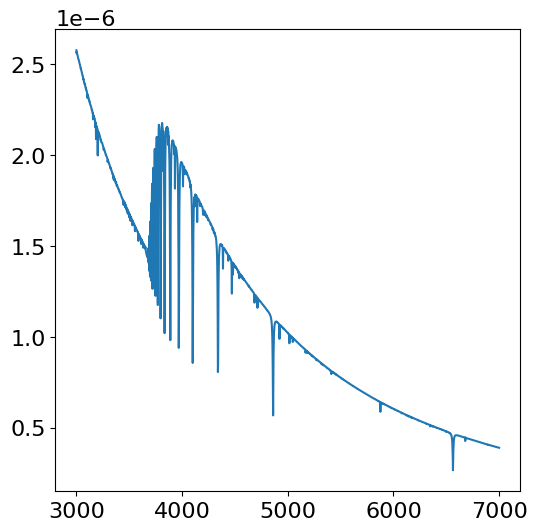

In [76]:
plt.plot(lam_c,spectra0001)

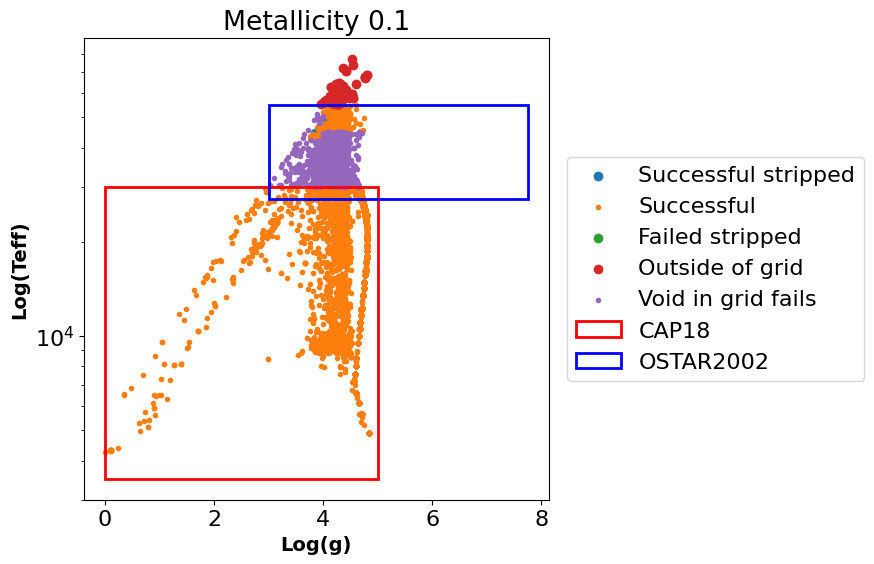

In [86]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(stripped_stars_run_logg,stripped_stars_run_Teff,label = 'Successful stripped')
plt.scatter(stars_run_logg ,stars_run_Teff,label ='Successful',marker = '.')

plt.scatter(stripped_stars_failed_run_logg,stripped_stars_failed_run_Teff,label= 'Failed stripped')
plt.scatter(stars_fails_logg,stars_fails_Teff,label = 'Outside of grid')
plt.scatter(stars_fail_grids_logg,stars_fail_grids_Teff,label = 'Void in grid fails',marker = ".")

plt.ylabel("Log(Teff)",fontweight ='bold', size=14)
plt.xlabel("Log(g)", fontweight ='bold',size=14)
left, bottom, width, height = (0, 3500.0, 5, 26500.0)
left1, bottom1, width1, height1 = (3.0, 27500.0, 4.75,27500.0 )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2,label ="CAP18" )
rect1=mpatches.Rectangle((left1,bottom1),width1,height1, 
                        fill=False,
                        color="blue",
                       linewidth=2,label='OSTAR2002')
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.gca().add_patch(rect1)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.yscale('log')
plt.title('Metallicity 0.1')
plt.show()

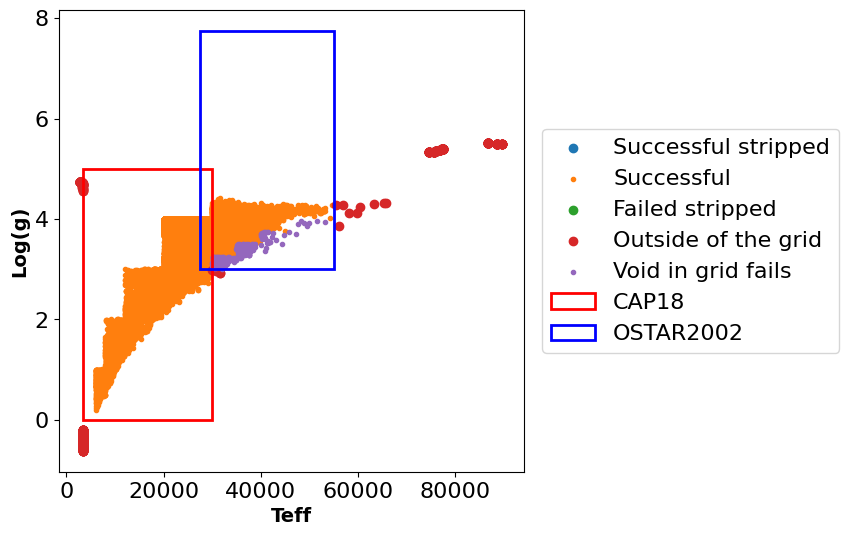

In [28]:

plt.scatter(stripped_stars_run_Teff,stripped_stars_run_logg,label = 'Successful stripped')
plt.scatter(stars_run_Teff ,stars_run_logg,label ='Successful',marker = '.')
#plt.scatter(stars_run1_Teff ,stars_run1_logg,label ='Successful',marker = '.')
plt.scatter(stripped_stars_failed_run_Teff,stripped_stars_failed_run_logg,label= 'Failed stripped')
plt.scatter(stars_fails_Teff,stars_fails_logg,label = 'Outside of the grid')
plt.scatter(stars_fail_grids_Teff,stars_fail_grids_logg,label = 'Void in grid fails',marker = ".")
plt.ylabel("Log(g)",fontweight ='bold', size=14)
plt.xlabel("Teff", fontweight ='bold',size=14)
left, bottom, width, height = ( 3500.0,0 , 26500.0,5)
left1, bottom1, width1, height1 = (27500.0, 3.0,27500.0 ,4.75)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2,label="CAP18")
rect1=mpatches.Rectangle((left1,bottom1),width1,height1, 
                        fill=False,
                        color="blue",
                       linewidth=2,label='OSTAR2002')
plt.gca().add_patch(rect)
plt.gca().add_patch(rect1)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()


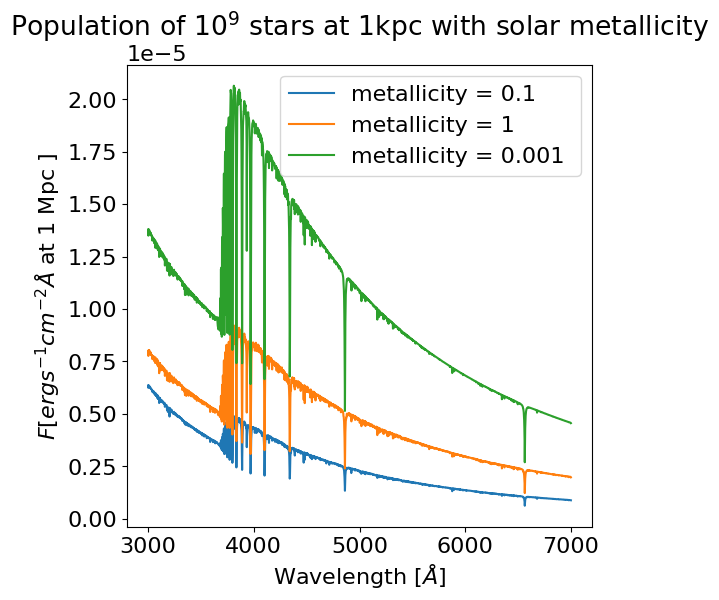

In [67]:
#plt.plot(lam_c,new_create_spelctrum_population(90))

#plt.plot(lam_c,spectra10,label = '10')
#plt.plot(lam_c, spectra15, label = '15')
plt.plot(lam_c, spectra01, label = 'metallicity = 0.1 ')
plt.plot(lam_c, spectra1, label = 'metallicity = 1')
plt.plot(lam_c, spectra001, label = 'metallicity = 0.001 ')
#plt.plot(lam_c, spectra40, label = '40')
#plt.plot(lam_c, spectra45, label = '45')#14510
#plt.plot(lam_c, spectra50, label = '50')#14539 failed due to spectral voids
plt.ylabel("$ F [erg s^{-1} cm^{-2} \AA  $ at 1 Mpc ]")
plt.xlabel("Wavelength [$ \AA $]")
plt.title("Population of $ 10^9$ stars at 1kpc with solar metallicity")
#plt.yscale('log')
plt.legend()
plt.show()

In [45]:
plt.plot(lam_c,spectrum_50*0.85*1e9/2e5*1e-6,label="50Myr")
#plt.plot(lam_c,spectrum_45,label="45Myr")
plt.plot(lam_c,spectrum_40*1e9/2e5*1e-6,label="40Myr")
plt.plot(lam_c,spectrum_30*1.24*1e9/2e5*1e-6,label="30Myr")
#plt.plot(lam_c,spectrum_25,label="25Myr")
#plt.plot(lam_c,spectrum_20,label="20Myr")
plt.plot(lam_c,spectrum_15*1e9/2e5*1e-6,label="15Myr")
plt.plot(lam_c,spectrum_10*1e9/2e5*1e-6,label='10Myr')
plt.yscale("log")
plt.ylabel("$ F_\lambda [erg s^{-1} cm^{-2} \AA  $ at 1 Mpc ]")
plt.xlabel("Wavelength [$ \AA $]")
plt.title("Populations of different times ")
plt.legend()
plt.show()

NameError: name 'spectrum_50' is not defined

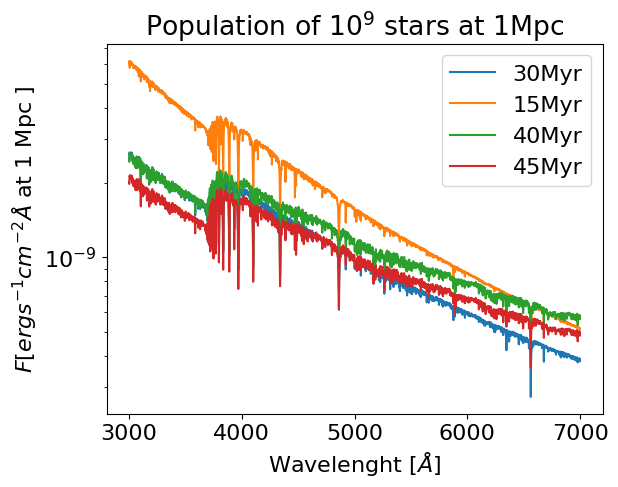

In [111]:


plt.plot(lam_c,spectrum_30*1e9/2e5*1e-6,label="30Myr")
#plt.plot(lam_c,1e9/2e5*spectrum_25*1e-6,label="25Myr")
plt.plot(lam_c,1e9/2e5*spectrum_15*1e-6,label="15Myr")
plt.plot(lam_c,spectrum_40*1e9/2e5*1e-6,label='40Myr')
plt.plot(lam_c,spectrum_45*1e9/2e5*1e-6,label="45Myr")
#plt.plot(lam_c,spectrum_15*1e9/2e5*1e-6,label='15Myr')
plt.yscale("log")
plt.ylabel("$ F [erg s^{-1} cm^{-2} \AA  $ at 1 Mpc ]")
plt.xlabel("Wavelenght [$ \AA $]")
plt.title("Population of $ 10^9$ stars at 1Mpc")
plt.legend()
plt.show()

## Investigating the data

In [77]:
binary = np.arange(100000)
str1 = "stripped"
index = 0 
for i in binary:
    if "stripped" in star_state(i,1):
        #if star_mass(i,"1")>2:
        #print(i,star_state(i,"1"),star_mass(i,"1"))
        index +=1
        #print(index,'binary_number:',i,star_state(i,1),star_mass(i,1)
    if "stripped" in star_state(i,2):
        #if star_mass(i,"1")>2:
        #print(i,star_state(i,"1"),star_mass(i,"1"))
        index +=1
print("Total_number_of_stripped_He_stars",index)
none = 0 
for i in binary:
    if math.isnan(star_mass(i,1)):
        none += 1
    if math.isnan(star_mass(i,2)):
        none += 1
print(none)
#Total number of stars is 200,000. 


Total_number_of_stripped_He_stars 1035
56950


In [79]:
iter= np.arange(0,100000,1)
total_out_of_bounds = 0 

total_failed = 0 
broken = 0 
for i in iter: 
    if star_state(i,1) == 'Failed': 
        broken +=1 
    elif star_state(i,2) == 'Failed':
         broken +=1 
    else: 
        if math.isnan(create_Teff(i,2)):
            #print(i,'less','binary_1',star_state(i,1),create_Teff(i,1))
            #print(total_less,i,'binary_1')
            total_failed +=1
        elif math.isnan(create_Teff(i,1)):
            total_failed +=1
        else:
            if create_Teff(i,1)<3500 or create_Teff(i,1)>30000:
            #print(i,'less','binary_1',star_state(i,1),create_Teff(i,1))
            #print(total_less,i,'binary_1')
                total_out_of_bounds += 1
        
            if create_Teff(i,2)<3500:
                total_less +=1
                #print(total_less,i,'binary_2')
                #print(i,'less','binary_2',star_state(i,1),create_Teff(i,2))
            elif create_Teff(i,2)>30000:
                total_more +=1
        #print(i,'more','binary_2',star_state(i,2),create_Teff(i,2))

print('Total_less: ',total_less)
print('Total_more: ',total_more)
print('Total_failed',total_failed)
print('Total_broken',broken)
print('Total_sum', total_less + total_more+total_failed+broken)
###############50:
#total_less = 6
#total_more = 2021
#toal_failed = 54227
#total = 56819
################45:
#total_less = 5
#total_more = 1990
#Total_broken 610
#toal_failed = 54300
#total = 56905

Total_less:  0
Total_more:  1450
Total_failed 87043
Total_broken 565
Total_sum 89058


In [213]:
class population_spectra():
    
    def __init__(self,total_binaries,first_binary_line,last_binary_line,data_file=None):
        ######Initializing the parameters ##################
        self.total_binaries = total_binaries
        self.data_file = data_file
        self.first_binary_line = first_binary_line
        self.last_binary_line = last_binary_line
        self.population = []
        self.spectra_status = True 
        
        
        
        mass,radius,L,state = array_data(self.total_binaries,self.last_binary_line,self.first_binary_line)
        
        for i in range(self.total_binaries):
            star1 = newstar(i,0,mass[i,0],state[i,0],radius[i,0],L[i,0])
            star2 = newstar(i,1,mass[i,1],state[i,1],radius[i,1],L[i,1])
            self.population.append((star1,star2))
        
        
    def create_spectrum_population(self):
        create_spectrum_population = F_empty*0
        failed_binaries = 0
        for binary in self.population:
            create_spectrum_population += self.create_spectrum_binary(binary)
        print(failedstar)
        return create_spectrum_population
    
    
    def create_spectrum_binary(self,binary):
    # check if binary has two non-degenerate stars
        star1 = binary[0]
        star2 = binary[1]
        if star1.state not in ['NS','BH','Failed']:
            spectrum_1 = new_create_spectrum_single(star1,star1.binary_number)
        else:
            spectrum_1 = F_empty*0

        if star2.state not in ['NS','BH','Failed']:
            spectrum_2 = new_create_spectrum_single(star2,star2.binary_number)
        else: 
            spectrum_2 =F_empty*0

        return new_add_spectra(spectrum_1, spectrum_2)

    
    
    
    def run_spectra():
        pass 


In [220]:
newpop = population_spectra(100000,first_binary_line50,last_binary_line50)

In [ ]:
st = datetime.datetime.now()
new_spectra = newpop.create_spectrum_population()
et = datetime.datetime.now()
elapsed_time = et - st 
print('Execution time: ', elapsed_time, 'seconds')



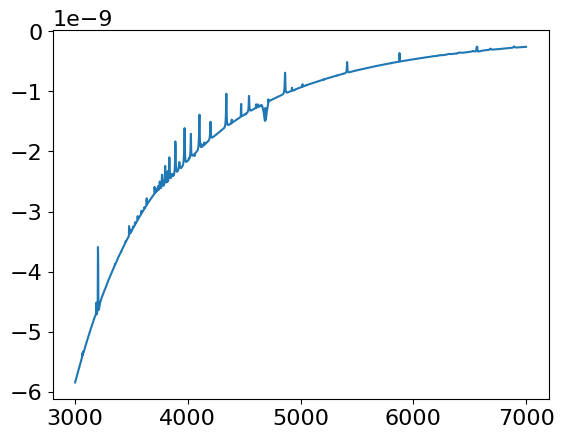

In [225]:
plt.plot(lam_c,spectra50-new_spectra)
#plt.plot(lam_c,spectra50)

In [212]:
def array_data(N,last_binary_line,first_binary_line):
    
    mass_arr = np.zeros((total_binaries,2))
    radius_arr = np.zeros((total_binaries,2))
    L_arr = np.zeros((total_binaries,2))
    state_arr = np.zeros((total_binaries,2),dtype=object)
    
    for i in range(N):
        try:
            mass_arr[i][:] = np.array([ last_binary_line.S1_mass[i], last_binary_line.S2_mass[i]])
            radius_arr[i][:] = np.array([ 10**last_binary_line.S1_log_R[i], 10**last_binary_line.S2_log_R[i]])
            L_arr[i][:] = np.array([ 10**last_binary_line.S1_log_L[i], 10**last_binary_line.S2_log_L[i]])
            state_arr[i][:] = np.array([ str(last_binary_line.S1_state[i]), str(last_binary_line.S2_state[i])])
        except:
            mass_arr[i][:] = np.array(None,None)
            radius_arr[i][:] = np.array(None,None)
            L_arr[i][:] =  np.array(None,None)
            state_arr[i][:] = np.array(["Failed","Failed"])
        finally:
            if "stripped" in state_arr[i][0]:
                mass_arr[i][0] = first_binary_line.S1_mass[i]
            elif "stripped" in state_arr[i][1]:
                mass_arr[i][1] = first_binary_line.S2_mass[i]
    
    return mass_arr,radius_arr,L_arr,state_arr
    
    
    

class newstar():
    
    def __init__(self,binary_number,number,mass,state,R,L):
        self.binary_number = binary_number
        self.number = number
        self.mass = mass*con.M_sun
        self.state = state
        self.R = R*con.R_sun
        self.L = L*con.L_sun
        self.logg = None
        self.Teff = None
        self.Fe_H = None
        
        
    def get_logg(self): 
        self.logg = np.log10(con.G*self.mass/self.R**2/(unt.cm/unt.s**2))
        if self.logg < max_logg and self.logg > min_logg:
            return self.logg
        else:
            return None
    
    def get_Teff(self):
        self.Teff = (self.L/(4*np.pi*self.R**2*con.sigma_sb))**0.25/unt.K
        if self.Teff < max_Teff and self.Teff > min_Teff:
            return self.Teff
        else:
            return None
        
    def set_metallicity(self,new_Fe_H):
        if new_Fe_H < max_Fe_H and new_Fe_H > min_Fe_H:
            self.Fe_H = new_Fe_H
        else: 
            raise TypeError
    #This is for the stars that we can't calculate their spectra so we change their logg and thus we need a new radius for them and we set and return. 
    def new_radius(self,new_logg):
        R = np.sqrt(con.G*self.mass/10**(new_logg)/unt.cm *unt.s**2).decompose()
        return R


In [203]:
#array_data(10000,last_binary_line45,first_binary_line45)